# 라이브러리 불러오기

In [320]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import catboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm
import time

In [418]:
train = pd.read_csv(r'..\Data\train.csv')
test = pd.read_csv(r'..\Data\test.csv')
submission = pd.read_csv(r'..\Data\sample_submission.csv')

# Feature 설명

index

gender: 성별   (o)

car: 차량 소유 여부   (o)

reality: 부동산 소유 여부   (o)

child_num: 자녀 수   

income_total: 연간 소득  (o)

income_type: 소득 분류   
    ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']   

edu_type: 교육 수준   
    ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']   

family_type: 결혼 여부   
    ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']   

house_type: 생활 방식   
    ['Municipal apartment', 'House / apartment', 'With parents','Co-op apartment', 'Rented apartment', 'Office apartment']   

DAYS_BIRTH: 출생일   (o)
    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미   

DAYS_EMPLOYED: 업무 시작일   (o)   
    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미,양수 값은 고용되지 않은 상태를 의미함   

FLAG_MOBIL: 핸드폰 소유 여부  (o) 

work_phone: 업무용 전화 소유 여부   (o)

phone: 전화 소유 여부  (o) 

email: 이메일 소유 여부   (o)

occyp_type: 직업 유형	   												

family_size: 가족 규모  (o) 

begin_month: 신용카드 발급 월 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미 (o)     

credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도   
=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함   

In [419]:
train.head()

index gender car reality  child_num  income_total           income_type  \
0      0      F   N       N          0      202500.0  Commercial associate   
1      1      F   N       Y          1      247500.0  Commercial associate   
2      2      M   Y       Y          0      450000.0               Working   
3      3      F   N       Y          0      202500.0  Commercial associate   
4      4      F   Y       Y          0      157500.0         State servant   

                        edu_type     family_type           house_type  \
0               Higher education         Married  Municipal apartment   
1  Secondary / secondary special  Civil marriage    House / apartment   
2               Higher education         Married    House / apartment   
3  Secondary / secondary special         Married    House / apartment   
4               Higher education         Married    House / apartment   

   DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  work_phone  phone  email  \
0      -13899          -4709           1           0      0      0   
1      -11380          -1540           1           0      0      1   
2      -19087          -4434           1           0      1      0   
3      -15088          -2092           1           0      1      0   
4      -15037          -2105           1           0      0      0   

    occyp_type  family_size  begin_month  credit  
0          NaN          2.0         -6.0     1.0  
1     Laborers          3.0         -5.0     1.0  
2     Managers          2.0        -22.0     2.0  
3  Sales staff          2.0        -37.0     0.0  
4     Managers          2.0        -26.0     2.0

In [420]:
print(train.shape)
print(test.shape)
train.info()

(26457, 20)
(10000, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-n

# 데이터 전처리
## 1. 결측치 제거

In [421]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [422]:
train_and_test = [train, test]

In [423]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

## - 중복된 데이터 처리

In [424]:
train['card_no'] = 0 #=> 중복된 데이터를 drop 하는 대신 제일 첫번째 데이터에 card_no라는 변수를 추가

In [425]:
train_overlap = pd.DataFrame(columns=train.columns)

In [426]:
for i in range (len(train)):
    overlap = train[(train['DAYS_BIRTH'] == train['DAYS_BIRTH'][i])&(train['income_total'] == train['income_total'][i])]
    overlap['card_no'][i] = (len(overlap))
    list_drop = overlap.index[1:].values.tolist()
    overlap = overlap.iloc[0:1]
    train = train.drop(list_drop, axis = 0)
    train_overlap = pd.concat([train_overlap, overlap])

KeyError: 192

In [360]:
# train_overlap.to_csv(r'..\Data\train_filtered.csv', index=False)

## - Child_num: 자녀의 유무로 구분 (nominal)

<AxesSubplot:>

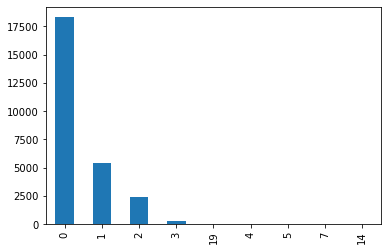

In [607]:
train['child_num'].value_counts(sort=False).plot.bar()

In [608]:
for dataset in train_and_test:
    dataset.loc[dataset['child_num'] != 0, 'child_num'] = 'kids_no'
    dataset.loc[dataset['child_num'] == 0, 'child_num'] = 'kids_yes'

# a for no kids/ b for whom has kids

## - income_total (ordinal)

(array([1.6212e+04, 8.3300e+03, 1.5300e+03, 2.0600e+02, 1.2100e+02,
        4.4000e+01, 3.0000e+00, 2.0000e+00, 4.0000e+00, 5.0000e+00]),
 array([  27000.,  181800.,  336600.,  491400.,  646200.,  801000.,
         955800., 1110600., 1265400., 1420200., 1575000.]),
 <BarContainer object of 10 artists>)

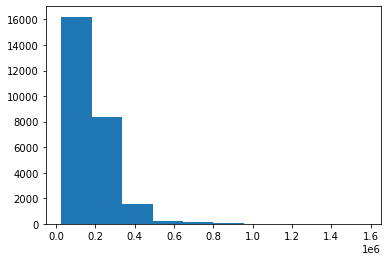

In [609]:
plt.hist(train['income_total'])

{'whiskers': [<matplotlib.lines.Line2D at 0x19e5457d790>,
 'caps': [<matplotlib.lines.Line2D at 0x19e5457de50>,
 'boxes': [<matplotlib.lines.Line2D at 0x19e5457d430>],
 'medians': [<matplotlib.lines.Line2D at 0x19e54589550>],
 'fliers': [<matplotlib.lines.Line2D at 0x19e545898b0>],
 'means': []}

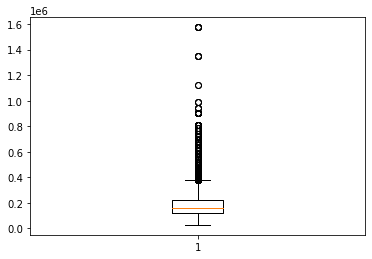

In [610]:
plt.boxplot(train['income_total']) # 이상치가 존재하나 범주형 데이터로 변형할 것이기에 그대로 사용한다.

In [611]:
for dataset in train_and_test:
    Q1 = dataset['income_total'].quantile(0.2)
    Q2 = dataset['income_total'].quantile(0.4)
    Q3 = dataset['income_total'].quantile(0.6)
    Q4 = dataset['income_total'].quantile(0.8)
    Q5 = dataset['income_total'].quantile(1.0)
    bins_income = [0, Q1, Q2, Q3, Q4, Q5]
    labels_income = ['a', 'b', 'c', 'd', 'e']
    cuts = pd.cut(dataset['income_total'], bins = bins_income, labels = labels_income, include_lowest= True)
    dataset['income_total'] = cuts

In [612]:
train['income_total'].value_counts()

a    6191
d    5389
c    5294
e    4856
b    4727
Name: income_total, dtype: int64

In [613]:
test

index gender car reality child_num income_total           income_type  \
0     26457      M   Y       N  kids_yes            a             Pensioner   
1     26458      F   N       Y  kids_yes            b         State servant   
2     26459      F   N       Y  kids_yes            a               Working   
3     26460      M   Y       N  kids_yes            a  Commercial associate   
4     26461      F   Y       Y  kids_yes            d         State servant   
...     ...    ...  ..     ...       ...          ...                   ...   
9995  36452      F   Y       Y  kids_yes            d               Working   
9996  36453      M   Y       Y  kids_yes            d               Working   
9997  36454      F   N       Y  kids_yes            e               Working   
9998  36455      F   Y       N  kids_yes            c  Commercial associate   
9999  36456      F   N       Y  kids_yes            e               Working   

                           edu_type     family_type         house_type  \
0     Secondary / secondary special  Civil marriage  House / apartment   
1                  Higher education         Married  House / apartment   
2     Secondary / secondary special         Married  House / apartment   
3     Secondary / secondary special         Married  House / apartment   
4                  Higher education         Married  House / apartment   
...                             ...             ...                ...   
9995              Incomplete higher         Married  House / apartment   
9996  Secondary / secondary special  Civil marriage  House / apartment   
9997  Secondary / secondary special         Married  House / apartment   
9998  Secondary / secondary special         Married  House / apartment   
9999               Higher education         Married  House / apartment   

      DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  work_phone  phone  email  \
0         -21990         365243           1           0      1      0   
1         -18964          -8671           1           0      1      0   
2         -15887           -217           1           1      1      0   
3         -19270          -2531           1           1      0      0   
4         -17822          -9385           1           1      0      0   
...          ...            ...         ...         ...    ...    ...   
9995      -18593          -5434           1           1      1      0   
9996      -10886          -1315           1           1      0      0   
9997      -21016         -14018           1           0      0      0   
9998      -16541          -1085           1           0      1      0   
9999       -9154           -187           1           0      0      1   

          occyp_type  family_size  begin_month  
0                NaN          2.0        -60.0  
1         Core staff          2.0        -36.0  
2           Laborers          2.0        -40.0  
3            Drivers          2.0        -41.0  
4           Managers          2.0         -8.0  
...              ...          ...          ...  
9995     Accountants          2.0        -19.0  
9996        Laborers          2.0        -34.0  
9997  Medicine staff          2.0        -55.0  
9998             NaN          2.0        -33.0  
9999        Laborers          2.0        -11.0  

[10000 rows x 19 columns]

## - Discrete variables

## - fanily_size (ordinal)

In [614]:
train['family_size'].value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

(array([1878., 5357.,    0., 1789.,    0.,  846.,  106.,    0.,   14.,
          10.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

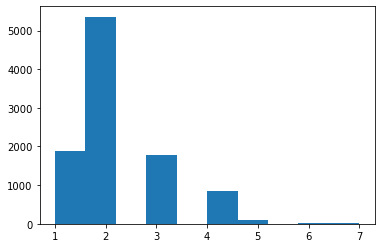

In [615]:
plt.hist(test['family_size'])

In [616]:
test.describe()

index    DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL    work_phone  \
count  10000.00000  10000.000000   10000.000000     10000.0  10000.000000   
mean   31456.50000 -16020.466400   59776.690400         1.0      0.227600   
std     2886.89568   4197.672887  138121.224504         0.0      0.419304   
min    26457.00000 -25152.000000  -15661.000000         1.0      0.000000   
25%    28956.75000 -19483.250000   -3153.000000         1.0      0.000000   
50%    31456.50000 -15606.000000   -1577.000000         1.0      0.000000   
75%    33956.25000 -12539.000000    -410.000000         1.0      0.000000   
max    36456.00000  -7489.000000  365243.000000         1.0      1.000000   

              phone         email   family_size   begin_month  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       0.296300      0.085600      2.202700    -26.272400  
std        0.456648      0.279786      0.898272     16.348557  
min        0.000000      0.000000      1.000000    -60.000000  
25%        0.000000      0.000000      2.000000    -39.000000  
50%        0.000000      0.000000      2.000000    -25.000000  
75%        1.000000      0.000000      3.000000    -12.000000  
max        1.000000      1.000000      7.000000      0.000000

In [617]:
for dataset in train_and_test:
    bins_family = [0, 1, 2, 21]
    labels_family = ['a', 'b', 'c']
    cuts = pd.cut(dataset['family_size'], bins = bins_family, labels = labels_family)
    dataset['family_size'] = cuts

# a for single, b for double, c for more than double

In [618]:
train['family_size'].isnull().sum()

0

## - income_type (nominal)

In [619]:
for dataset in train_and_test:
    dataset.loc[dataset['income_type']=='Student', 'income_type'] = 'Working' # ==> student 데이터의 수가 적고 working 데이터가 크고 다양하다는 점에서 편입함.

## - edu_type (ordinal)

In [620]:
train['edu_type'].value_counts()

Secondary / secondary special    17995
Higher education                  7162
Incomplete higher                 1020
Lower secondary                    257
Academic degree                     23
Name: edu_type, dtype: int64

In [621]:
test

index gender car reality child_num income_total           income_type  \
0     26457      M   Y       N  kids_yes            a             Pensioner   
1     26458      F   N       Y  kids_yes            b         State servant   
2     26459      F   N       Y  kids_yes            a               Working   
3     26460      M   Y       N  kids_yes            a  Commercial associate   
4     26461      F   Y       Y  kids_yes            d         State servant   
...     ...    ...  ..     ...       ...          ...                   ...   
9995  36452      F   Y       Y  kids_yes            d               Working   
9996  36453      M   Y       Y  kids_yes            d               Working   
9997  36454      F   N       Y  kids_yes            e               Working   
9998  36455      F   Y       N  kids_yes            c  Commercial associate   
9999  36456      F   N       Y  kids_yes            e               Working   

                           edu_type     family_type         house_type  \
0     Secondary / secondary special  Civil marriage  House / apartment   
1                  Higher education         Married  House / apartment   
2     Secondary / secondary special         Married  House / apartment   
3     Secondary / secondary special         Married  House / apartment   
4                  Higher education         Married  House / apartment   
...                             ...             ...                ...   
9995              Incomplete higher         Married  House / apartment   
9996  Secondary / secondary special  Civil marriage  House / apartment   
9997  Secondary / secondary special         Married  House / apartment   
9998  Secondary / secondary special         Married  House / apartment   
9999               Higher education         Married  House / apartment   

      DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  work_phone  phone  email  \
0         -21990         365243           1           0      1      0   
1         -18964          -8671           1           0      1      0   
2         -15887           -217           1           1      1      0   
3         -19270          -2531           1           1      0      0   
4         -17822          -9385           1           1      0      0   
...          ...            ...         ...         ...    ...    ...   
9995      -18593          -5434           1           1      1      0   
9996      -10886          -1315           1           1      0      0   
9997      -21016         -14018           1           0      0      0   
9998      -16541          -1085           1           0      1      0   
9999       -9154           -187           1           0      0      1   

          occyp_type family_size  begin_month  
0                NaN           b        -60.0  
1         Core staff           b        -36.0  
2           Laborers           b        -40.0  
3            Drivers           b        -41.0  
4           Managers           b         -8.0  
...              ...         ...          ...  
9995     Accountants           b        -19.0  
9996        Laborers           b        -34.0  
9997  Medicine staff           b        -55.0  
9998             NaN           b        -33.0  
9999        Laborers           b        -11.0  

[10000 rows x 19 columns]

In [622]:
test.groupby(['edu_type', 'income_total'])['income_total'].value_counts() # 확인해본 결과 석박사 과정과 대졸의 소득 분포가 큰 차이를 보이지 않기에 데이터를 합침.

edu_type                       income_total  income_total
Academic degree                b             b                  2
                               e             e                  7
Higher education               a             a                358
                               b             b                355
                               c             c                599
                               d             d                547
                               e             e                843
Incomplete higher              a             a                 46
                               b             b                 79
                               c             c                 94
                               d             d                 67
                               e             e                104
Lower secondary                a             a                 49
                               b             b                 21
                  

In [623]:
for dataset in train_and_test:
    dataset.loc[dataset['edu_type']=='Academic degree', 'edu_type'] = 'Higher education'
    dataset.loc[dataset['edu_type']=='Lower secondary', 'edu_type'] = 'Secondary / secondary special'

In [624]:
train['edu_type'].value_counts()

Secondary / secondary special    18252
Higher education                  7185
Incomplete higher                 1020
Name: edu_type, dtype: int64

In [625]:
for dataset in train_and_test:
  dataset.loc[dataset['edu_type'] == 'Secondary / secondary special', 'edu_type'] = 'a'
  dataset.loc[dataset['edu_type'] == 'Incomplete higher', 'edu_type'] = 'b'
  dataset.loc[dataset['edu_type'] == 'Higher education', 'edu_type'] = 'c'

## - family_type (nominal)

In [626]:
train['family_type'].value_counts()

Married                 18196
Single / not married     3496
Civil marriage           2123
Separated                1539
Widow                    1103
Name: family_type, dtype: int64

## - house_type (nominal)

In [627]:
train['house_type'].value_counts()
train['house_type'].unique()

array(['Municipal apartment', 'House / apartment', 'With parents',
       'Co-op apartment', 'Rented apartment', 'Office apartment'],
      dtype=object)

In [628]:
test.groupby(['house_type', 'income_total'])['income_total'].value_counts() # 확인해본 결과 아파트 종류들의 소득 분포가 큰 차이를 보이지 않기에 데이터를 합침.

house_type           income_total  income_total
Co-op apartment      a             a                 16
                     b             b                  6
                     c             c                 13
                     d             d                 14
                     e             e                  9
House / apartment    a             a               2164
                     b             b               1444
                     c             c               1928
                     d             d               1545
                     e             e               1814
Municipal apartment  a             a                 83
                     b             b                 37
                     c             c                 91
                     d             d                 57
                     e             e                 42
Office apartment     a             a                 11
                     b             b                  7


In [629]:
for dataset in train_and_test:
    houses = ['Municipal apartment', 'Co-op apartment', 'Rented apartment', 'Office apartment']
    for type in houses:
        dataset.loc[dataset['house_type']==type, 'house_type'] = 'etc_apartment'

In [630]:
train.head()

index gender car reality child_num income_total           income_type  \
0      0      F   N       N  kids_yes            d  Commercial associate   
1      1      F   N       Y   kids_no            d  Commercial associate   
2      2      M   Y       Y  kids_yes            e               Working   
3      3      F   N       Y  kids_yes            d  Commercial associate   
4      4      F   Y       Y  kids_yes            c         State servant   

  edu_type     family_type         house_type  DAYS_BIRTH  DAYS_EMPLOYED  \
0        c         Married      etc_apartment      -13899          -4709   
1        a  Civil marriage  House / apartment      -11380          -1540   
2        c         Married  House / apartment      -19087          -4434   
3        a         Married  House / apartment      -15088          -2092   
4        c         Married  House / apartment      -15037          -2105   

   FLAG_MOBIL  work_phone  phone  email   occyp_type family_size  begin_month  \
0           1           0      0      0          NaN           b         -6.0   
1           1           0      0      1     Laborers           c         -5.0   
2           1           0      1      0     Managers           b        -22.0   
3           1           0      1      0  Sales staff           b        -37.0   
4           1           0      0      0     Managers           b        -26.0   

   credit  
0     1.0  
1     1.0  
2     2.0  
3     0.0  
4     2.0

## - DAYS_EMPLOYED (ordinal)
-  근무일수 데이터 중 양수의 값을 가지는 데이터를 0->Unemployed로 바꾼 후 각 분위에 해당하는 데이터를 'Short', 'Medium', 'Long', 'Very_Long'로 변환함.

 - [a < b < c < d < e] -> ['Unemployed', 'Short', 'Medium', 'Long', 'Very_Long']

In [631]:
# 'DAYS_EMPLOYED' preprocessing
for dataset in train_and_test:
    dataset['DAYS_EMPLOYED'] = dataset['DAYS_EMPLOYED'].replace(365243, 0)
    dataset['DAYS_EMPLOYED'] = dataset['DAYS_EMPLOYED'].abs()

    Q1 = dataset['DAYS_EMPLOYED'].quantile(0.25)
    Q2 = dataset['DAYS_EMPLOYED'].quantile(0.50)
    Q3 = dataset['DAYS_EMPLOYED'].quantile(0.75)

    bins = [0,1, Q1, Q2, Q3, 15713]
    labels = ['a', 'b', 'c', 'd', 'e']
    cuts = pd.cut(dataset['DAYS_EMPLOYED'], bins, right=True, labels=labels, include_lowest= True)
    dataset['DAYS_EMPLOYED'] = cuts


In [632]:
train['DAYS_EMPLOYED'].value_counts()

c    6639
d    6608
e    6591
a    4438
b    2181
Name: DAYS_EMPLOYED, dtype: int64

In [633]:
test['DAYS_EMPLOYED'].isnull().sum()

0

## - DAYS_BIRTH: (ordinal)
살아온 일수를 절대값을 취한 후 연단위로 바꾸어 반올림함.

 - ['20s', '30s', '40s', '50s', '60s'] => ['a', 'b', 'c', 'd', 'e']

In [634]:
for dataset in train_and_test:
    dataset['DAYS_BIRTH'] = (dataset['DAYS_BIRTH']/365).abs().astype(object)
    bins = [20, 30, 40, 50, 60, 70]
    labels = ['a', 'b', 'c', 'd', 'e']
    cuts = pd.cut(dataset['DAYS_BIRTH'], bins = bins, right=True, labels=labels, include_lowest= True)
    dataset['DAYS_BIRTH'] = cuts
    # pd.get_dummies(dataset['DAYS_BIRTH'])

In [635]:
dataset['DAYS_BIRTH'].value_counts()

b    2851
c    2543
d    2213
a    1320
e    1073
Name: DAYS_BIRTH, dtype: int64

In [636]:
train['DAYS_BIRTH'].value_counts()
train['DAYS_BIRTH'].isnull().sum()

0

In [637]:
test['DAYS_BIRTH'].value_counts()
test['DAYS_BIRTH'].isnull().sum()

0

In [638]:
train['DAYS_BIRTH'].value_counts()

b    7588
c    6766
d    5739
a    3608
e    2756
Name: DAYS_BIRTH, dtype: int64

In [639]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   index          26457 non-null  int64   
 1   gender         26457 non-null  object  
 2   car            26457 non-null  object  
 3   reality        26457 non-null  object  
 4   child_num      26457 non-null  object  
 5   income_total   26457 non-null  category
 6   income_type    26457 non-null  object  
 7   edu_type       26457 non-null  object  
 8   family_type    26457 non-null  object  
 9   house_type     26457 non-null  object  
 10  DAYS_BIRTH     26457 non-null  category
 11  DAYS_EMPLOYED  26457 non-null  category
 12  FLAG_MOBIL     26457 non-null  int64   
 13  work_phone     26457 non-null  int64   
 14  phone          26457 non-null  int64   
 15  email          26457 non-null  int64   
 16  occyp_type     18286 non-null  object  
 17  family_size    26457 non-null  

## occupation (nominal)

In [640]:
train.occyp_type.value_counts()

Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

In [641]:
train['occyp_type'] = train['occyp_type'].fillna('no')
test['occyp_type'] = test['occyp_type'].fillna('no')

In [642]:
for dataset in train_and_test:
    dataset.loc[(dataset['occyp_type'] == 'no')&(dataset['DAYS_EMPLOYED'] != 'Unemployed'), 'occyp_type'] = 'no_response'
    dataset.loc[(dataset['occyp_type'] == 'no')&(dataset['DAYS_EMPLOYED'] == 'Unemployed'), 'occyp_type'] = 'no_job'

In [643]:
for dataset in train_and_test:
  dataset['occyp_type'] = dataset['occyp_type'].replace(['Private service staff', 'Low-skill Laborers', 'Waiters/barmen staff', 'Secretaries', 'Realty agents', 'HR staff', 'IT staff'], 'etc')

In [644]:
test['occyp_type'].value_counts()

no_response              3152
Laborers                 1699
Sales staff               946
Core staff                945
Managers                  845
Drivers                   563
Medicine staff            343
High skill tech staff     343
Accountants               339
etc                       311
Cooking staff             198
Security staff            168
Cleaning staff            148
Name: occyp_type, dtype: int64

In [645]:
train['occyp_type'].value_counts()

no_response              8171
Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
etc                       757
Cooking staff             457
Security staff            424
Cleaning staff            403
Name: occyp_type, dtype: int64

## begin_month (ordinal)
### 음수 값을 가진 데이터를 절대값을 취해주었으며, 0의 값을 가진 데이터의 경우 카드를 소지하지 않은 경우로 판단함.

In [646]:
# train['begin_month'].describe()

In [647]:
# train['begin_month'].head()
# train['begin_month'].describe() # 0의 값이 존재함 -> 어떤 의미? -> 카드를 발급받지 아니한 사람 (사유: 다양함 --> 신용불량, 소득 X, 신용등급이 낮은 사회 초년생 등)
# train['begin_month'].isnull().sum() # 결측치 없음
# len(train.loc[train['begin_month'] == 0, :]) # 카드를 소지하지 않은 사람의 수가 231명으로 보임.

In [648]:
# train['begin_month'] = train['begin_month'].abs()/12 # 음수 값을 가지던 데이터에 절대값처리.

In [649]:
# train['begin_month'].value_counts

In [650]:
# bins = [0, 0.001, 1, 2, 3, 4, 5]
# labels = ['NoCard', '0_year', '1_year', '2_year', '3_year', '4+_years']
# cuts = pd.cut(train['begin_month'], bins = bins, right=True, labels=labels, include_lowest= True)
# train['begin_month'] = cuts
# train['begin_month'].value_counts()


- ['NoCard', '0_year', '1_year', '2_year', '3_year', '4+_years'] => ['a', 'b', 'c', 'd', 'e', 'f']

In [651]:
for dataset in train_and_test:
    dataset['begin_month'] = dataset['begin_month'].abs()/12
    bins = [0, 0.001, 1, 2, 3, 4, 5]
    labels = ['a', 'b', 'c', 'd', 'e', 'f']
    cuts = pd.cut(dataset['begin_month'], bins = bins, right=True, labels=labels, include_lowest= True)
    dataset['begin_month'] = cuts

In [652]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   index          26457 non-null  int64   
 1   gender         26457 non-null  object  
 2   car            26457 non-null  object  
 3   reality        26457 non-null  object  
 4   child_num      26457 non-null  object  
 5   income_total   26457 non-null  category
 6   income_type    26457 non-null  object  
 7   edu_type       26457 non-null  object  
 8   family_type    26457 non-null  object  
 9   house_type     26457 non-null  object  
 10  DAYS_BIRTH     26457 non-null  category
 11  DAYS_EMPLOYED  26457 non-null  category
 12  FLAG_MOBIL     26457 non-null  int64   
 13  work_phone     26457 non-null  int64   
 14  phone          26457 non-null  int64   
 15  email          26457 non-null  int64   
 16  occyp_type     26457 non-null  object  
 17  family_size    26457 non-null  

## 트레인 테스트 셋으로 전처리

In [653]:
train_x = train.drop(['credit', 'index'], axis = 1)
train_y = train[['credit']]
test_x = test.drop('index', axis = 1)

## encoding (one_hot_encoding for nominal, ordinal_encoding for ordinal)

In [654]:
# feat_ordinal = ['begin_month','income_total', 'edu_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size']
# feat_nominal = ['car', 'reality', 'child_num', 'income_type', 'family_type', 'house_type', 'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type' ]

In [655]:
# train_nom = pd.get_dummies(train_x[feat_nominal], drop_first=True) 
# train_ord = train_x[feat_ordinal]
# encoder = OrdinalEncoder()
# encoder.fit(train_ord.values.tolist())
# train_ord_encoded = encoder.transform(train_ord.values.tolist())
# train_ord = pd.DataFrame(train_ord_encoded, columns= feat_ordinal)
# train_x = pd.concat([train_nom, train_ord], axis = 1)

In [663]:
# test_nom = pd.get_dummies(test_x[feat_nominal], drop_first=True) 
# test_ord = test_x[feat_ordinal]
# encoder = OrdinalEncoder()
# encoder.fit(test_ord.values.tolist())
# test_ord_encoded = encoder.transform(test_ord.values.tolist())
# test_ord = pd.DataFrame(test_ord_encoded, columns= feat_ordinal)
# test_x = pd.concat([test_nom, test_ord], axis = 1)

# [데이터 모델링]

In [667]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   FLAG_MOBIL                        26457 non-null  int64  
 1   work_phone                        26457 non-null  int64  
 2   phone                             26457 non-null  int64  
 3   email                             26457 non-null  int64  
 4   car_Y                             26457 non-null  uint8  
 5   reality_Y                         26457 non-null  uint8  
 6   child_num_kids_yes                26457 non-null  uint8  
 7   income_type_Pensioner             26457 non-null  uint8  
 8   income_type_State servant         26457 non-null  uint8  
 9   income_type_Working               26457 non-null  uint8  
 10  family_type_Married               26457 non-null  uint8  
 11  family_type_Separated             26457 non-null  uint8  
 12  fami

In [668]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   FLAG_MOBIL                        10000 non-null  int64  
 1   work_phone                        10000 non-null  int64  
 2   phone                             10000 non-null  int64  
 3   email                             10000 non-null  int64  
 4   car_Y                             10000 non-null  uint8  
 5   reality_Y                         10000 non-null  uint8  
 6   child_num_kids_yes                10000 non-null  uint8  
 7   income_type_Pensioner             10000 non-null  uint8  
 8   income_type_State servant         10000 non-null  uint8  
 9   income_type_Working               10000 non-null  uint8  
 10  family_type_Married               10000 non-null  uint8  
 11  family_type_Separated             10000 non-null  uint8  
 12  famil

In [ ]:
# print(train_x.shape, test_x.shape, train_y.shape)

In [669]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)

Train set: 
(19842, 34)
(19842, 1)
Validation set: 
(6615, 34)
(6615, 1)


In [ ]:
# rf_clf=RandomForestClassifier()
# rf_clf.fit(X_train, y_train)
# y_pred_rf=rf_clf.predict_proba(X_val)
# rf_clf.classes_

# # print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred_rf)}")

In [ ]:
# gbm_clf=GradientBoostingClassifier()
# gbm_clf.fit(X_train, y_train)
# y_pred_gbm=gbm_clf.predict_proba(X_val)

# print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred_gbm)}")

In [ ]:
# ada_clf=AdaBoostClassifier()
# ada_clf.fit(X_train, y_train)
# y_pred_ada=ada_clf.predict_proba(X_val)

# print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred_ada)}")

In [670]:
cbt_clf = CatBoostClassifier()
cbt_clf.fit(X_train, y_train)
y_pred_cbt = cbt_clf.predict_proba(X_val)


print("훈련 세트 정확도: {:.3f}".format(cbt_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(cbt_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred_cbt)}")

Learning rate set to 0.092151
0:	learn: 1.0555595	total: 164ms	remaining: 2m 43s
1:	learn: 1.0210746	total: 192ms	remaining: 1m 35s
2:	learn: 0.9932685	total: 199ms	remaining: 1m 6s
3:	learn: 0.9698924	total: 207ms	remaining: 51.7s
4:	learn: 0.9513433	total: 222ms	remaining: 44.2s
5:	learn: 0.9352720	total: 229ms	remaining: 38s
6:	learn: 0.9219334	total: 238ms	remaining: 33.7s
7:	learn: 0.9106317	total: 254ms	remaining: 31.5s
8:	learn: 0.9018432	total: 257ms	remaining: 28.3s
9:	learn: 0.8940724	total: 264ms	remaining: 26.1s
10:	learn: 0.8873364	total: 301ms	remaining: 27s
11:	learn: 0.8817920	total: 307ms	remaining: 25.3s
12:	learn: 0.8769961	total: 346ms	remaining: 26.2s
13:	learn: 0.8731759	total: 352ms	remaining: 24.8s
14:	learn: 0.8697945	total: 358ms	remaining: 23.5s
15:	learn: 0.8668846	total: 379ms	remaining: 23.3s
16:	learn: 0.8645006	total: 394ms	remaining: 22.8s
17:	learn: 0.8620265	total: 407ms	remaining: 22.2s
18:	learn: 0.8599280	total: 440ms	remaining: 22.7s
19:	learn: 0.

In [671]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(cbt_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        cbt_clf.fit(X_train, y_train)
        
        predictions=cbt_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=cbt_clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(cbt_clf)

Learning rate set to 0.092455
0:	learn: 1.0551811	total: 33.8ms	remaining: 33.8s
1:	learn: 1.0204454	total: 45.8ms	remaining: 22.8s
2:	learn: 0.9924705	total: 62.7ms	remaining: 20.8s
3:	learn: 0.9688999	total: 77.5ms	remaining: 19.3s
4:	learn: 0.9502252	total: 109ms	remaining: 21.7s
5:	learn: 0.9341907	total: 115ms	remaining: 19s
6:	learn: 0.9213047	total: 121ms	remaining: 17.2s
7:	learn: 0.9105089	total: 138ms	remaining: 17.1s
8:	learn: 0.9013250	total: 154ms	remaining: 17s
9:	learn: 0.8933156	total: 169ms	remaining: 16.8s
10:	learn: 0.8864984	total: 185ms	remaining: 16.6s
11:	learn: 0.8811416	total: 191ms	remaining: 15.8s
12:	learn: 0.8764107	total: 197ms	remaining: 15s
13:	learn: 0.8723370	total: 203ms	remaining: 14.3s
14:	learn: 0.8688243	total: 216ms	remaining: 14.2s
15:	learn: 0.8660106	total: 246ms	remaining: 15.1s
16:	learn: 0.8633326	total: 262ms	remaining: 15.1s
17:	learn: 0.8611366	total: 277ms	remaining: 15.1s
18:	learn: 0.8594711	total: 294ms	remaining: 15.2s
19:	learn: 0.

<BarContainer object of 34 artists>

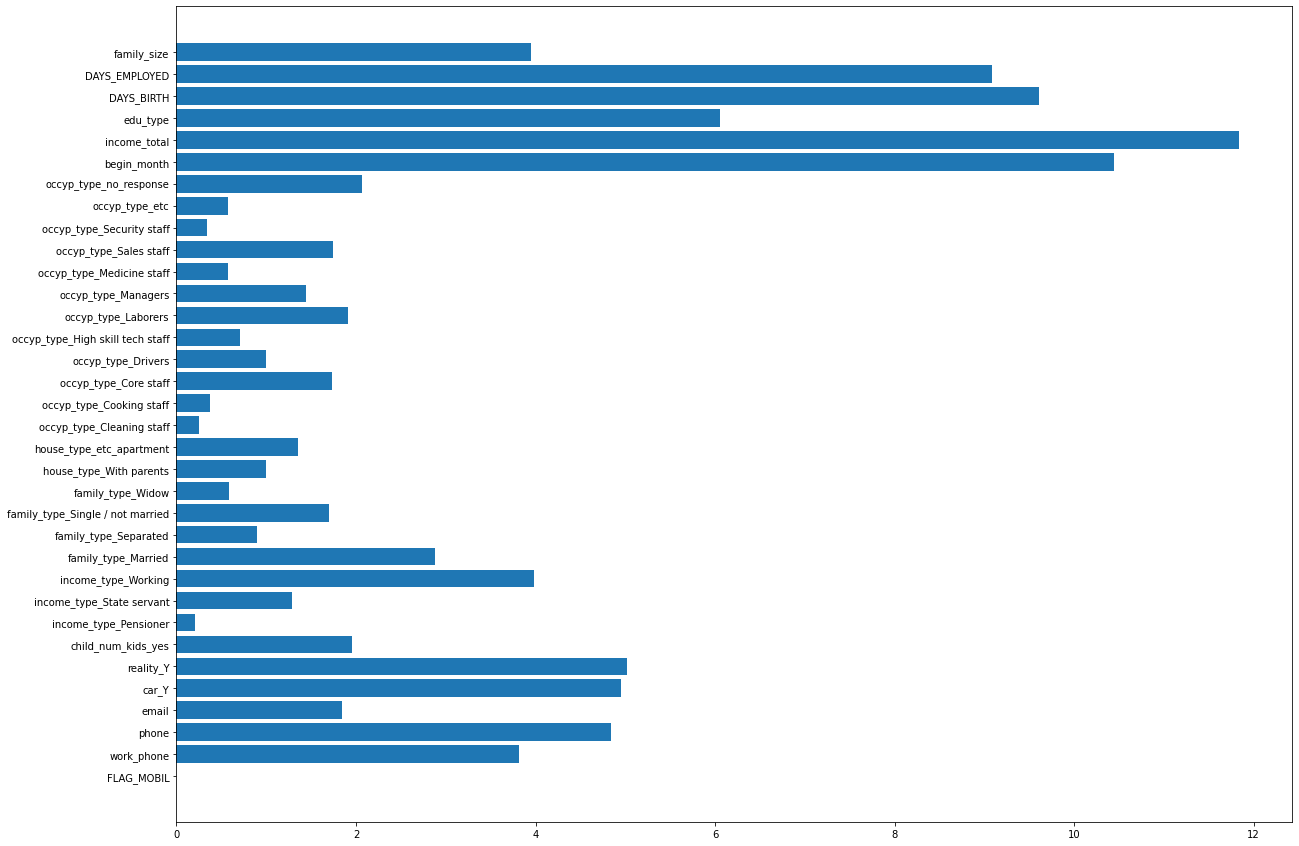

In [675]:
cbt_clf.get_feature_importance()

plt.figure(figsize=(20, 15))

plt.barh(X_train.columns, cbt_clf.get_feature_importance())

In [676]:
my_submission

array([[0.07620161, 0.0777338 , 0.84606459],
       [0.18160171, 0.1362881 , 0.68211019],
       [0.0919039 , 0.12991402, 0.77818208],
       ...,
       [0.02882377, 0.13095139, 0.84022484],
       [0.09434046, 0.14388594, 0.76177361],
       [0.0488301 , 0.65499492, 0.29617498]])

In [678]:
submission

index  0  1  2
0     26457  0  0  0
1     26458  0  0  0
2     26459  0  0  0
3     26460  0  0  0
4     26461  0  0  0
...     ... .. .. ..
9995  36452  0  0  0
9996  36453  0  0  0
9997  36454  0  0  0
9998  36455  0  0  0
9999  36456  0  0  0

[10000 rows x 4 columns]

In [1011]:
my_submission.shape

(10000, 3)

In [679]:
submission.loc[:, 1:] = my_submission

In [683]:
submission

index         0         1         2
0     26457  0.076202  0.077734  0.846065
1     26458  0.181602  0.136288  0.682110
2     26459  0.091904  0.129914  0.778182
3     26460  0.168005  0.075411  0.756584
4     26461  0.065175  0.301594  0.633231
...     ...       ...       ...       ...
9995  36452  0.131168  0.197640  0.671192
9996  36453  0.118279  0.321281  0.560440
9997  36454  0.028824  0.130951  0.840225
9998  36455  0.094340  0.143886  0.761774
9999  36456  0.048830  0.654995  0.296175

[10000 rows x 4 columns]

In [682]:
# submission.to_csv(r'..\Data\submission_JH_cbt6.csv', index=False)